<a href="https://colab.research.google.com/github/JACKARPANJACK/AI-Lab-6th-sem/blob/main/Assessment1_ADL_LAB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error

import geopandas as gpd
from shapely.geometry import Point


In [ ]:
base_path = "/content/drive/MyDrive/NWMP/"

df_july = pd.read_csv(base_path + "NWMP_July2025.csv", encoding="latin1")
df_aug  = pd.read_csv(base_path + "NWMP_August2025_MPCB_0.csv", encoding="latin1")
df_sep  = pd.read_csv(base_path + "NWMP_September2025_MPCB_0.csv", encoding="latin1")

In [ ]:
df_july["Month"] = "Jul"
df_aug["Month"]  = "Aug"
df_sep["Month"]  = "Sep"


In [ ]:
train_df = pd.concat([df_july, df_aug], ignore_index=True)
test_df  = df_sep.copy()

print("Training samples:", train_df.shape)
print("Testing samples:", test_df.shape)

Training samples: (444, 55)
Testing samples: (222, 54)


In [ ]:
chem_cols = ["Nitrate N", "Boron", "Potassium", "Flouride"]

for col in chem_cols:
    train_df[col] = pd.to_numeric(train_df[col], errors="coerce")
    test_df[col]  = pd.to_numeric(test_df[col], errors="coerce")

train_df.dropna(subset=chem_cols, inplace=True)
test_df.dropna(subset=chem_cols, inplace=True)

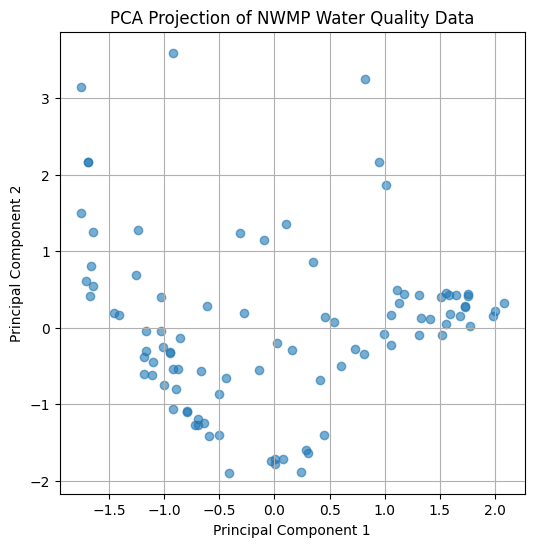

In [ ]:
full_df = pd.concat([train_df, test_df], ignore_index=True)

X = full_df[chem_cols]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(6,6))
plt.scatter(X_pca[:,0], X_pca[:,1], alpha=0.6)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Projection of NWMP Water Quality Data")
plt.grid(True)
plt.show()

In [ ]:
X_train = train_df[["Nitrate N", "Boron"]]
X_test  = test_df[["Nitrate N", "Boron"]]

results_even = {}

for target in ["Potassium", "Flouride"]:
    y_train = train_df[target]
    y_test  = test_df[target]

    # Linear Regression
    lin_reg = LinearRegression()
    lin_reg.fit(X_train, y_train)
    mse_lr = mean_squared_error(y_test, lin_reg.predict(X_test))

    # Logistic Regression
    y_train_bin = (y_train > y_train.mean()).astype(int)
    y_test_bin  = (y_test > y_train.mean()).astype(int)

    log_reg = LogisticRegression(max_iter=1000)
    log_reg.fit(X_train, y_train_bin)
    mse_log = mean_squared_error(y_test_bin, log_reg.predict(X_test))

    results_even[target] = {
        "Linear MSE": mse_lr,
        "Logistic MSE": mse_log
    }

results_even

{'Potassium': {'Linear MSE': 9347.75847720668, 'Logistic MSE': 0.0},
 'Flouride': {'Linear MSE': 0.056861290604786056, 'Logistic MSE': 0.6875}}

In [ ]:
def dms_to_decimal(dms):
    dms = str(dms).replace("°", " ").replace("'", " ").replace("\x92", " ").strip()
    parts = dms.split()
    if len(parts) < 2:
        return np.nan # Not enough parts for DMS
    try:
        return float(parts[0]) + float(parts[1])/60
    except ValueError:
        return np.nan # Parts cannot be converted to float

full_df["lat"] = full_df["latitude"].apply(dms_to_decimal)
full_df["lon"] = full_df["longitude"].apply(dms_to_decimal)

# Drop rows where latitude or longitude conversion failed
full_df.dropna(subset=['lat', 'lon'], inplace=True)

naturalearth_lowres data already exists.


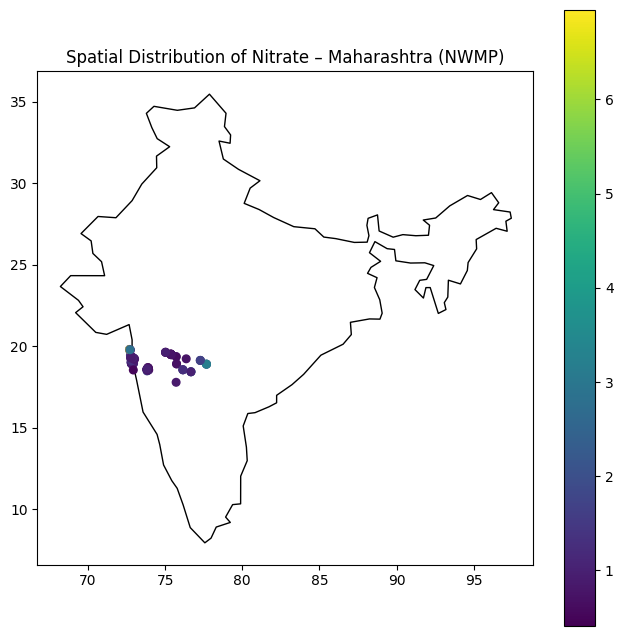

In [ ]:
import requests
import zipfile
import os

geometry = [Point(xy) for xy in zip(full_df["lon"], full_df["lat"])]
gdf = gpd.GeoDataFrame(full_df, geometry=geometry, crs="EPSG:4326")

# --- Fix for deprecated geopandas.datasets ---
# Define the URL for the naturalearth_lowres data
url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
output_dir = "/tmp/naturalearth_lowres" # Temporary directory for downloaded files
os.makedirs(output_dir, exist_ok=True)
zip_path = os.path.join(output_dir, "ne_110m_admin_0_countries.zip")
shp_path = os.path.join(output_dir, "ne_110m_admin_0_countries.shp")

# Download and extract if not already done
if not os.path.exists(shp_path):
    print("Downloading naturalearth_lowres data...")
    # Add a User-Agent header to mimic a web browser
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'}
    response = requests.get(url, stream=True, headers=headers) # Use stream=True for potentially large files

    response.raise_for_status() # Raise an HTTPError for bad responses (4xx or 5xx)

    # Check Content-Type header
    content_type = response.headers.get('Content-Type', '')
    if 'application/zip' not in content_type:
        print(f"Error: Expected 'application/zip', but got '{content_type}'")
        raise Exception("Downloaded file is not a zip archive.")

    with open(zip_path, "wb") as f:
        # Instead of f.write(response.content), stream the content
        for chunk in response.iter_content(chunk_size=8192):
            if chunk:
                f.write(chunk)
    print("Download complete. Attempting extraction.")

    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(output_dir)
        print("Extraction complete.")
    except zipfile.BadZipFile:
        print(f"Error: Downloaded file '{zip_path}' is not a valid zip file.")
        print("This might indicate a corrupted download or server issue.")
        raise # Re-raise the exception to show the original traceback
else:
    print("naturalearth_lowres data already exists.")

# Load the shapefile
india = gpd.read_file(shp_path)
india = india[india.ADMIN == "India"]

fig, ax = plt.subplots(figsize=(8,8))
india.plot(ax=ax, color="white", edgecolor="black")
gdf.plot(
    ax=ax,
    column="Nitrate N",
    cmap="viridis",
    legend=True,
    markersize=30
)

plt.title("Spatial Distribution of Nitrate – Maharashtra (NWMP)")
plt.show()